# Capstone 2 milestone report

Executive Summary

This milestone report is intended to demonstrate the initial steps taken towards the overall project goal of finding bike share count predictive algorithm based on unique features. This is part of the Capstone class in the Springboard data science specialization. The dataset used in developing a model was downloaded from the UCI repository. 

The problem

Given the Bike Sharing dataset with hourly level information of bikes along with weather and 
other attributes, model a system which can predict the bike count.

The client

The client could be a business interested in renting bikes and wants to know how many bikes could be
shared in an hour or so. It could also be a government entity who wants to decrease a carbon foot 
print in the corresponding metropolitan area.

Data Set Information

Bike sharing systems are new generation of traditional bike rentals where entire process from membership,
rental and return has become automatic. Through these systems, user can easily rent a bike from a 
position and return at another position. Currently, there are about over 500 bike-sharing programs 
around the world which is composed of over 500 thousand bicycles. Today, there exists great interest in
these systems due to their key role in traffic, environmental and health issues. 
    Apart from interesting real-world applications of bike sharing systems, 
    the characteristics of data being generated by these systems make them attractive for the research.
    Opposed to other transport services such as bus or subway, the duration of travel, departure and 
    arrival position is explicitly recorded in these systems. This feature turns bike sharing system
    into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is 
    expected that most of notable events in the city could be detected via monitoring these data.
    
 Attribute Information:

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv

- instant: record index

- dteday : date

- season : season (1:springer, 2:summer, 3:fall, 4:winter)

- yr : year (0: 2011, 1:2012)

- mnth : month ( 1 to 12)

- hr : hour (0 to 23)

- holiday : weather day is holiday or not (extracted from [Web Link])

- weekday : day of the week

- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.

+ weathersit : 

- 1: Clear, Few clouds, Partly cloudy, Partly cloudy

- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min),
t_min=-8, t_max=+39 (only in hourly scale)

- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

- hum: Normalized humidity. The values are divided to 100 (max)

- windspeed: Normalized wind speed. The values are divided to 67 (max)

- casual: count of casual users

- registered: count of registered users

- cnt: count of total rental bikes including both casual and registered


Data wrangling

The provided data files were processed using panda’s tools. Summary statistics such as dataset
size were gathered to better understand the contents of the files. Missing and unknown objects were
removed. I have standardized the column name to make it more readable. I type cast the attributes to 
reflect the intended values of the columns.
Visualization of the hourly distribution counts give us different interesting relationships.
The season wise hourly distribution of counts shows that in all the seasons there are peaks around
8AM and 5PM which are considered to be rush hours.
The analysis of hourly counts by weekday wise hourly distribution shows that on average weekdays have
a higher usage than weekends. The analysis of a random hourly distribution of counts shows that early
hours and late nights have low counts, but significant outliers as do afternoon hours. Peak hours have
higher medians and counts with virtually no outliers.
The monthly distribution of total counts shows that the highest counts occur from June to October of 
the year which makes senses as it’s the fall season of the year.
If we have other datasets that could explain the nature of our bikes or their efficiencies, it could 
help as improve our bike share count. Moreover, having a dataset that explains the hourly weather 
condition could also be very helpful.
I investigated the effects of the features have on bike share count. The collinearity between
features was also investigated to determine which features are more important to predict bike share count.

In [190]:
#Import the required libraries.The libraries are updated to reflect python version 3.6
import requests,io,os,csv
import tarfile, zipfile, gzip
%matplotlib inline
import numpy as np
import pandas as pd
import pydotplus 
from sklearn import tree,metrics,preprocessing
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split,KFold
import seaborn as sn
import matplotlib.pyplot as plt
import timeit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

This milestone report is intended to demonstrate the initial steps taken towards the overall project goal of finding bike share count predictive algorithm based on unique features. This is part of the Capstone class in the Springboard data science specialization. The dataset used in developing a model was downloaded from the UCI repository. 

In [191]:
# setting params
params = {'legend.fontsize': 'x-large','figure.figsize': (30, 10),'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large','xtick.labelsize':'x-large','ytick.labelsize':'x-large'}
sn.set_style('whitegrid')
sn.set_context('talk')
plt.rcParams.update(params)
pd.options.display.max_colwidth = 600


# Load Dataset

In [192]:
#let's get and unpack datasets from UCI in zip format
def unzip_from_UCI(UCI_url, dest=''):
    response = requests.get(UCI_url)
    compressed_file = io.BytesIO(response.content)
    z = zipfile.ZipFile(compressed_file)
    print ('Extracting in %s' % os.getcwd()+'\\'+dest)
    for name in z.namelist():
        if '.csv' in name:
            print ('\tunzipping %s' %name)
            z.extract(name, path=os.getcwd()+'\\'+dest)

# Bike Sharing Dataset

In [193]:
#let's get the dataset from the UCI repository
UCI_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
unzip_from_UCI(UCI_url,dest='bikesharing')

Extracting in C:\Users\seid\bikesharing
	unzipping day.csv
	unzipping hour.csv


In [194]:
#The current path we are working on
local_path = os.getcwd()
source = 'bikesharing\\hour.csv'
SEP = ','
with open(local_path+'\\'+source,"rt") as R:
    iterator = csv.reader(R, delimiter=SEP)
    for n, row in enumerate(iterator):
        if n==0:
            header = row
        else:
            pass
    print ('Total rows: %i' % (n+1))
    print ('Header: %s' % ', '.join(header))
    

Total rows: 17380
Header: instant, dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt


In [195]:
hour_df = pd.read_csv(source)
print("Shape of dataset::{}".format(hour_df.shape))

Shape of dataset::(17379, 17)


# Rename Attributes

In [196]:
hour_df.rename(columns={'instant':'rec_id','dteday':'datetime','holiday':'is_holiday',
                        'workingday':'is_workingday', 'weathersit':'weather_condition','hum':'humidity',
                        'mnth':'month','cnt':'total_count',
                      'hr':'hour','yr':'year'},inplace=True)

# Typecast Attributes

In [197]:
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)
# categorical variables
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')


# Visualize Hourly distribution counts

[Text(0.5,1,'Seasonwise hourly distribution of counts')]

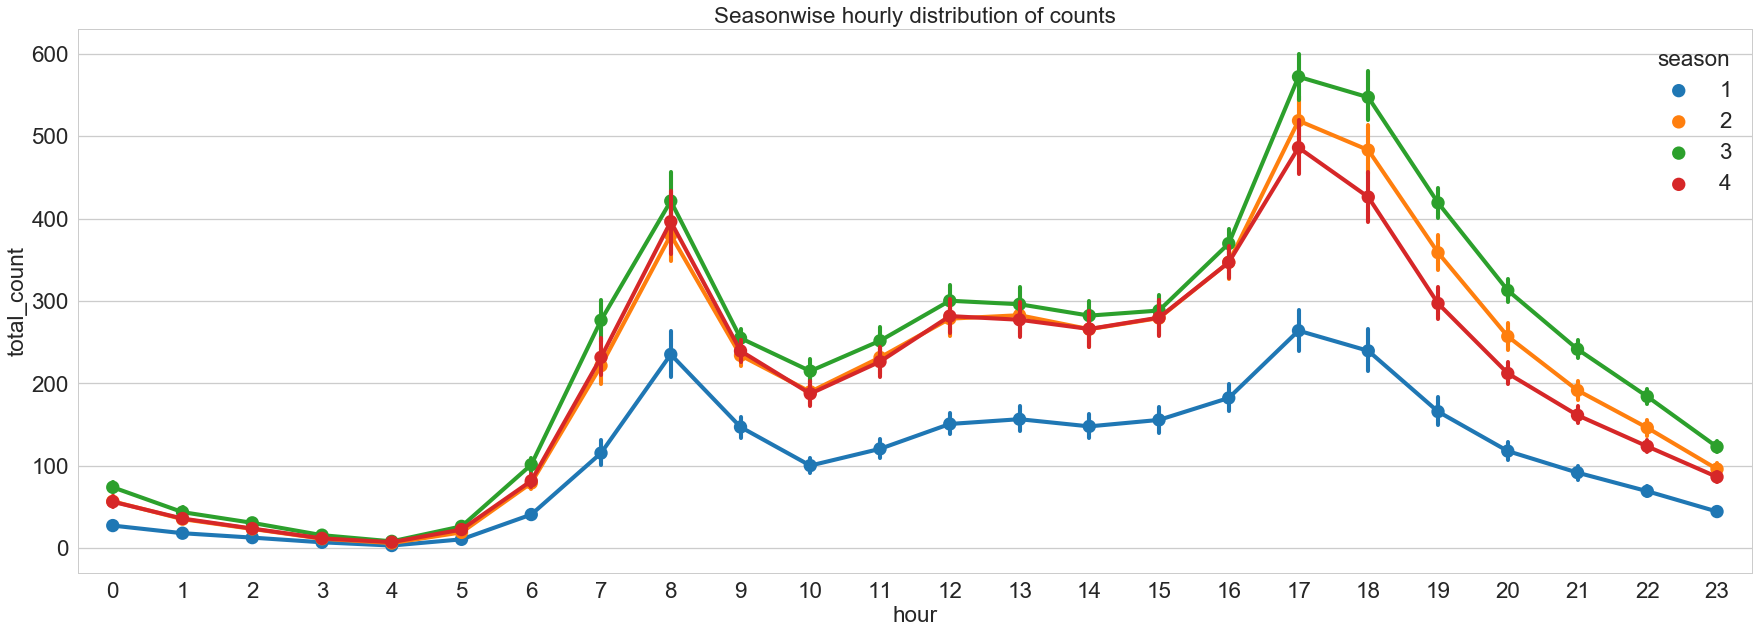

In [198]:
# Hourly distribution of Total Counts
#Seasons are encoded as 1:spring, 2:summer, 3:fall, 4:winter
fig,ax = plt.subplots()
sn.pointplot(data=hour_df[['hour','total_count','season']],
             x='hour',y='total_count',hue='season',ax=ax)
ax.set(title="Seasonwise hourly distribution of counts")
#The plot shows peaks around (rush hours)8am and 5pm and higher usage in the second half of the day

[Text(0.5,1,'Weekdaywise hourly distribution of counts')]

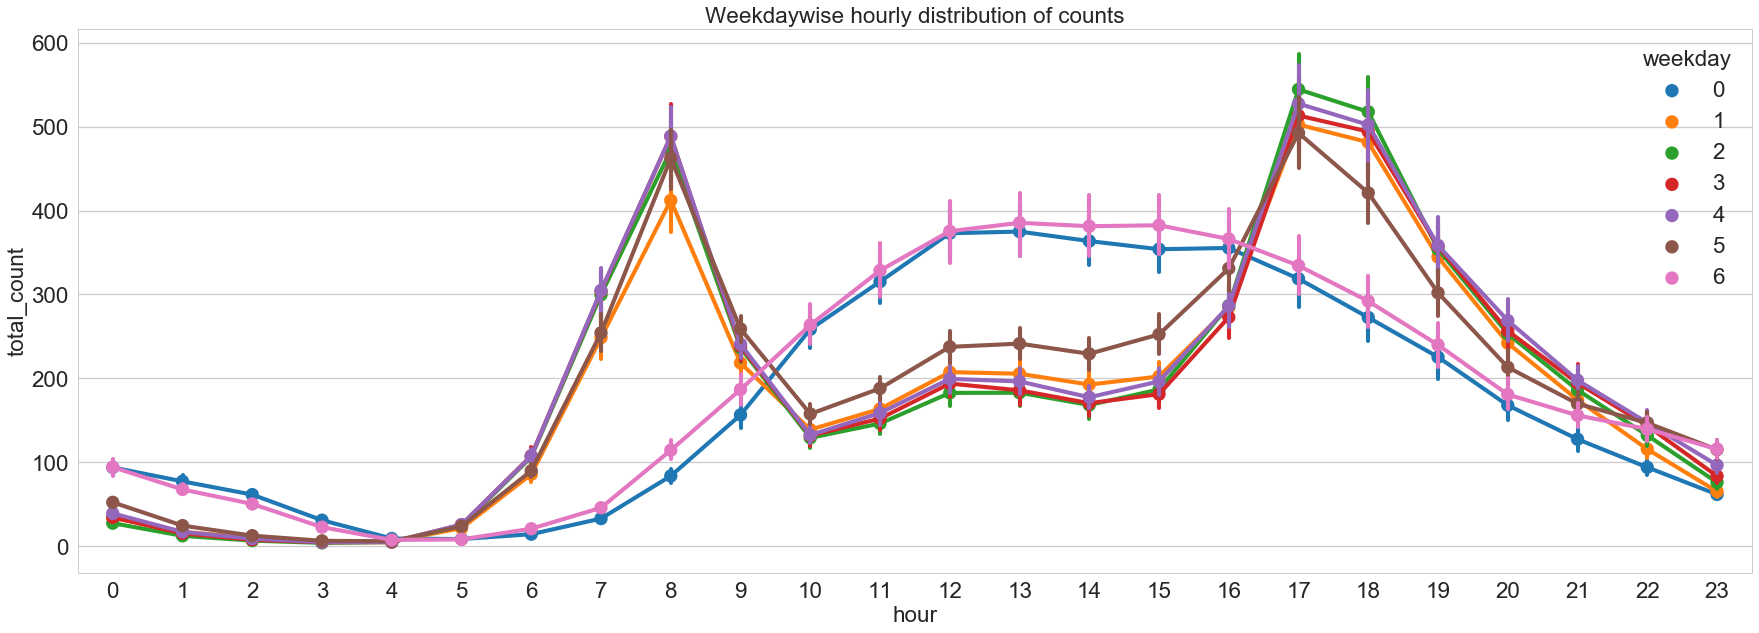

In [199]:
fig,ax = plt.subplots()
sn.pointplot(data=hour_df[['hour','total_count','weekday']],x='hour',y='total_count',hue='weekday',ax=ax)
ax.set(title="Weekdaywise hourly distribution of counts")
#Weekends (0 and 6) and Weekdays (1-5) show different usage trends with weekend's peak usage in
#during afternoon hours.Weekdays have higher usage as compared to weekends.

[Text(0.5,1,'Box Pot for hourly distribution of counts')]

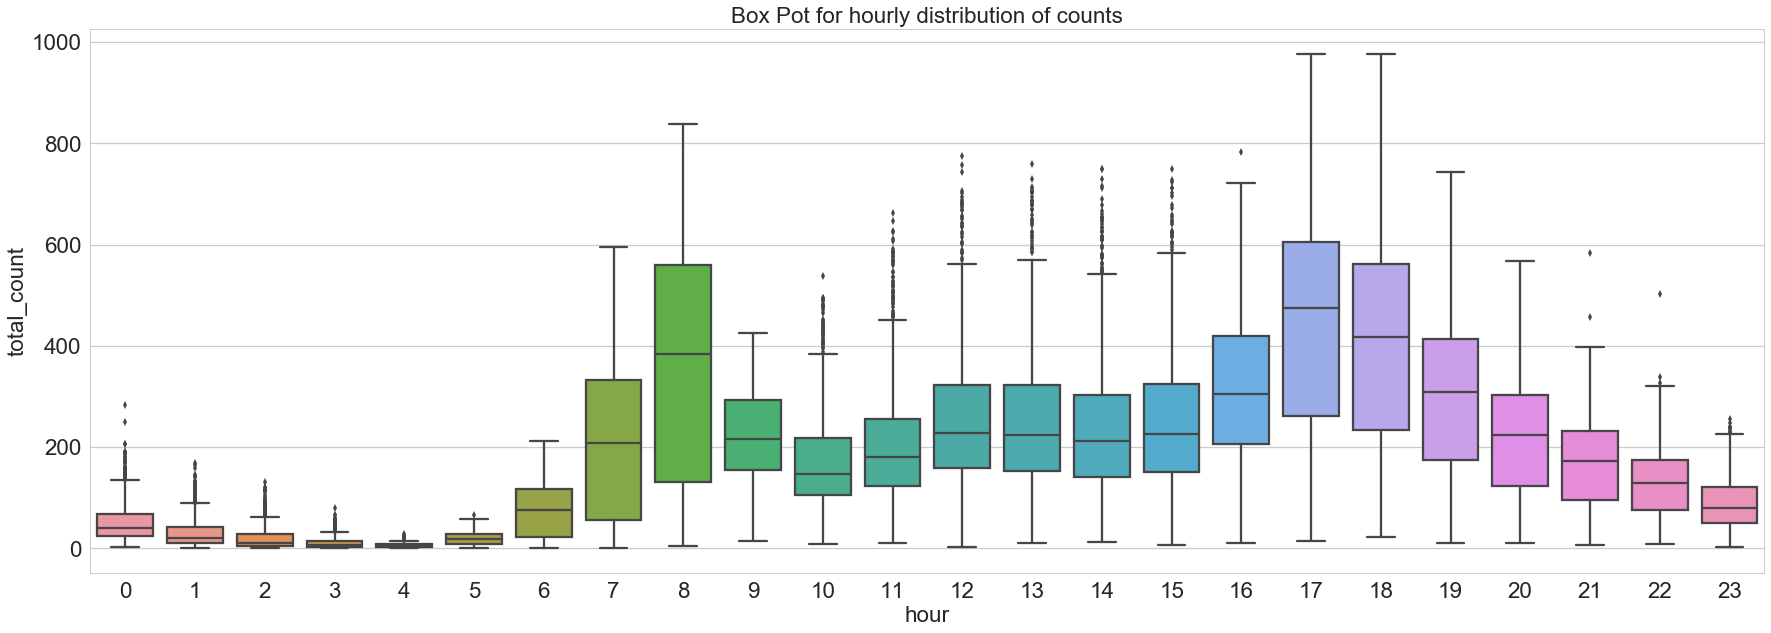

In [200]:
fig,ax = plt.subplots()
sn.boxplot(data=hour_df[['hour','total_count']],x="hour",y="total_count",ax=ax)
ax.set(title="Box Pot for hourly distribution of counts")
#Early hours (0-4) and late nights (21-23) have low counts but significant outliers as do afternoon hours
#Peak hours have higher medians and counts with virtually no outliers

# Monthly distribution of Total Counts

[Text(0.5,1,'Monthly distribution of counts')]

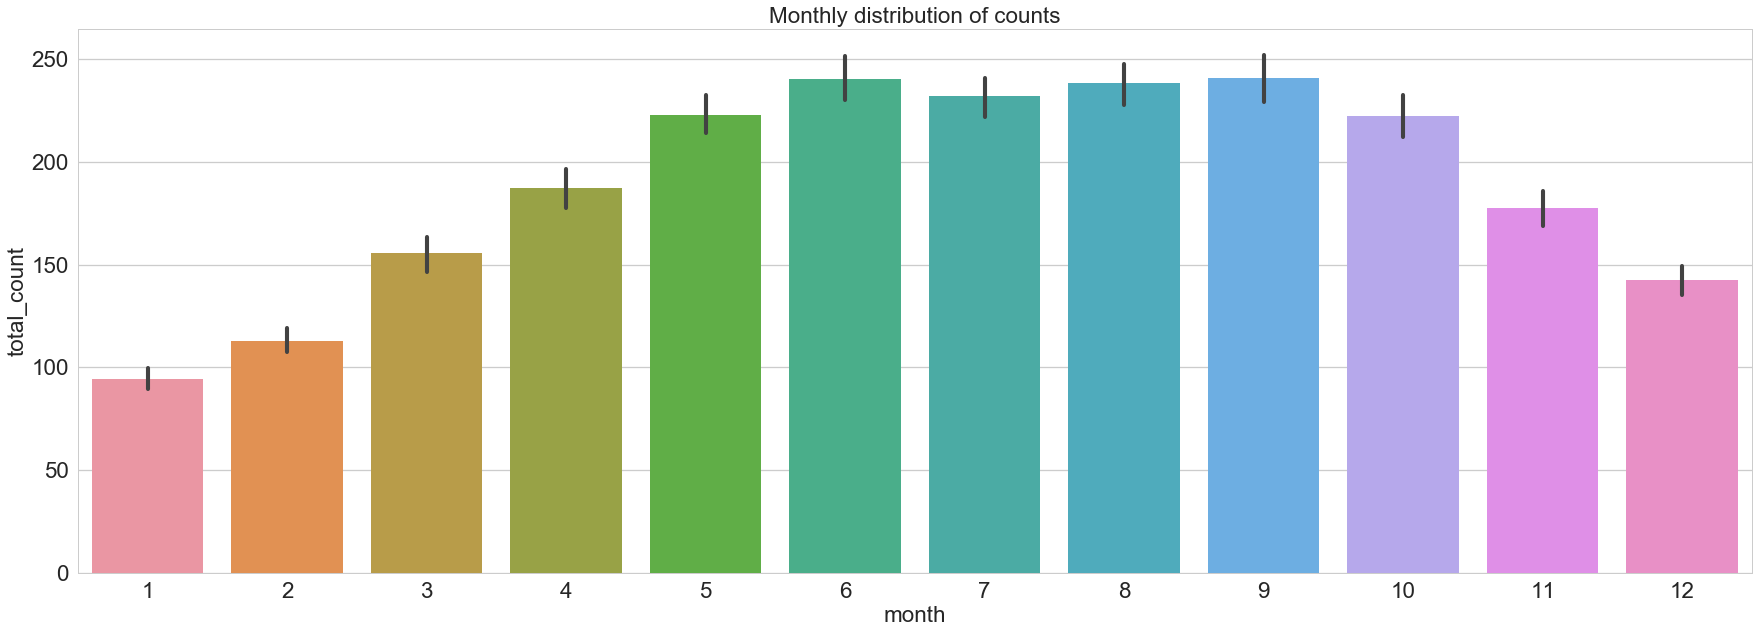

In [201]:
fig,ax = plt.subplots()
sn.barplot(data=hour_df[['month','total_count']],x="month",y="total_count")
ax.set(title="Monthly distribution of counts")
#Months June-Oct have highest counts. Fall seems to be favorite time of the year to use bikes

[Text(0.5,1,'Winter')]

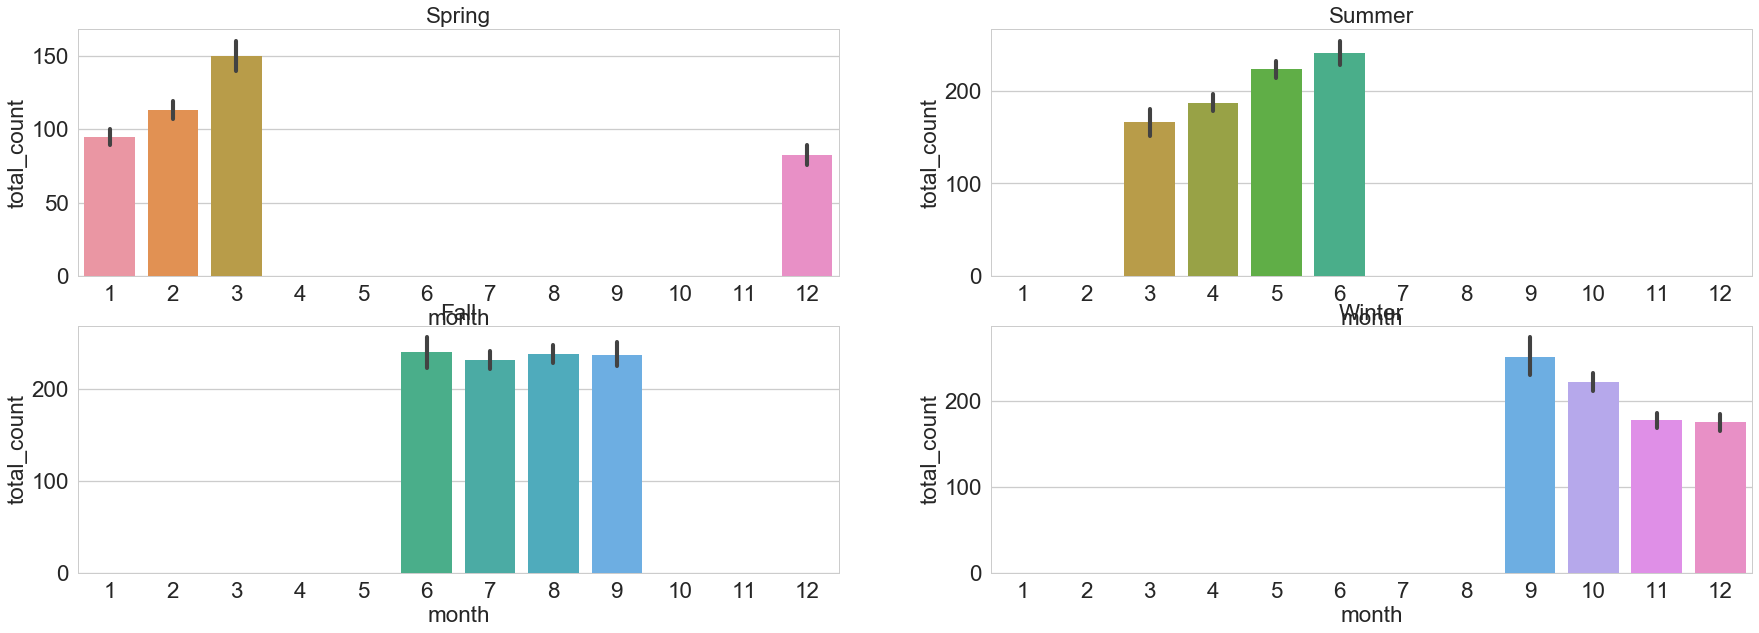

In [202]:

df_col_list = ['month','weekday','total_count']
plot_col_list= ['month','total_count']
spring_df = hour_df[hour_df.season==1][df_col_list]
summer_df = hour_df[hour_df.season==2][df_col_list]
fall_df = hour_df[hour_df.season==3][df_col_list]
winter_df = hour_df[hour_df.season==4][df_col_list]

fig,ax= plt.subplots(nrows=2,ncols=2)
sn.barplot(data=spring_df[plot_col_list],x="month",y="total_count",ax=ax[0][0],)
ax[0][0].set(title="Spring")

sn.barplot(data=summer_df[plot_col_list],x="month",y="total_count",ax=ax[0][1])
ax[0][1].set(title="Summer")

sn.barplot(data=fall_df[plot_col_list],x="month",y="total_count",ax=ax[1][0])
ax[1][0].set(title="Fall")

sn.barplot(data=winter_df[plot_col_list],x="month",y="total_count",ax=ax[1][1])  
ax[1][1].set(title="Winter")

# Year Wise Count Distributions

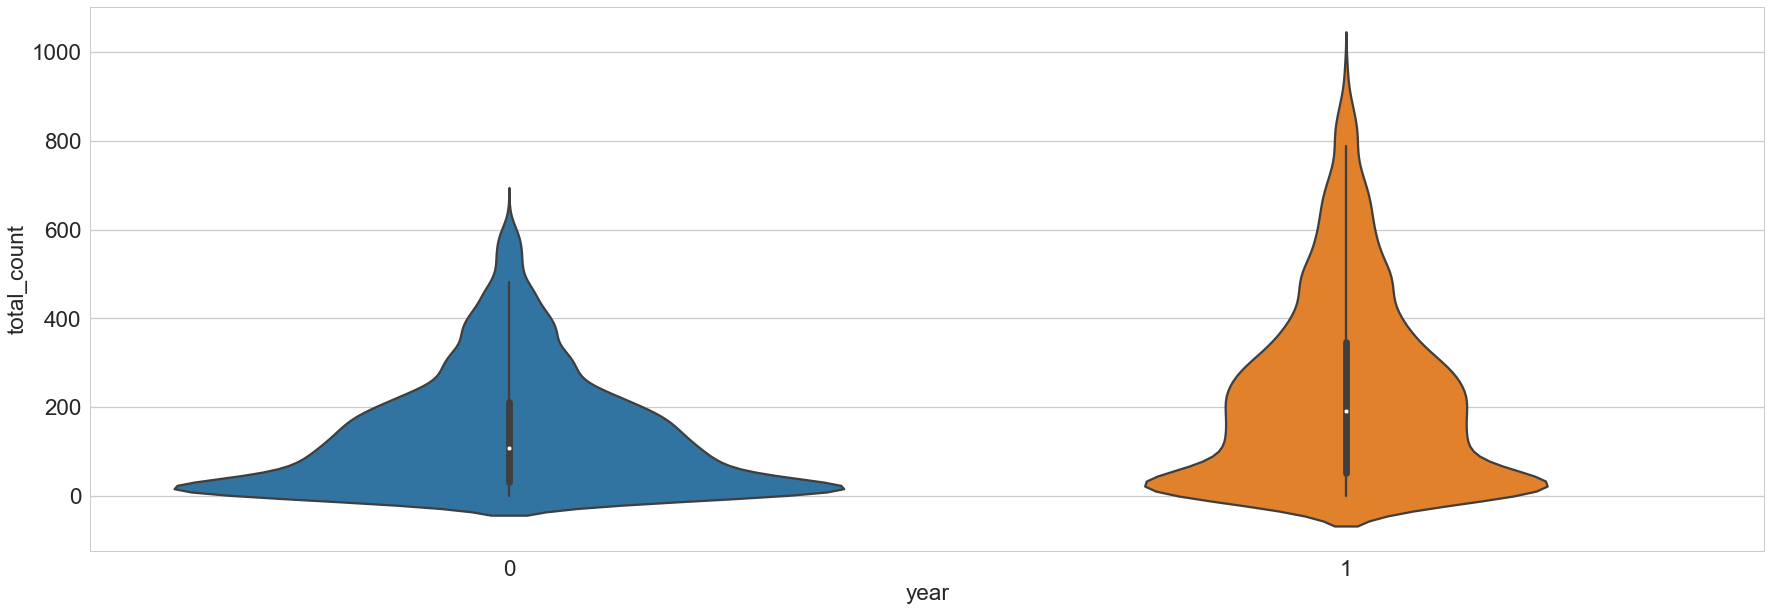

In [203]:
sn.violinplot(data=hour_df[['year','total_count']],x="year",y="total_count")
#2011 has lower counts overall with a lower median.2012 has a higher
#max count the peaks are b/n 100 and 300 then tapering off

# Working Day Vs Holiday Distribution

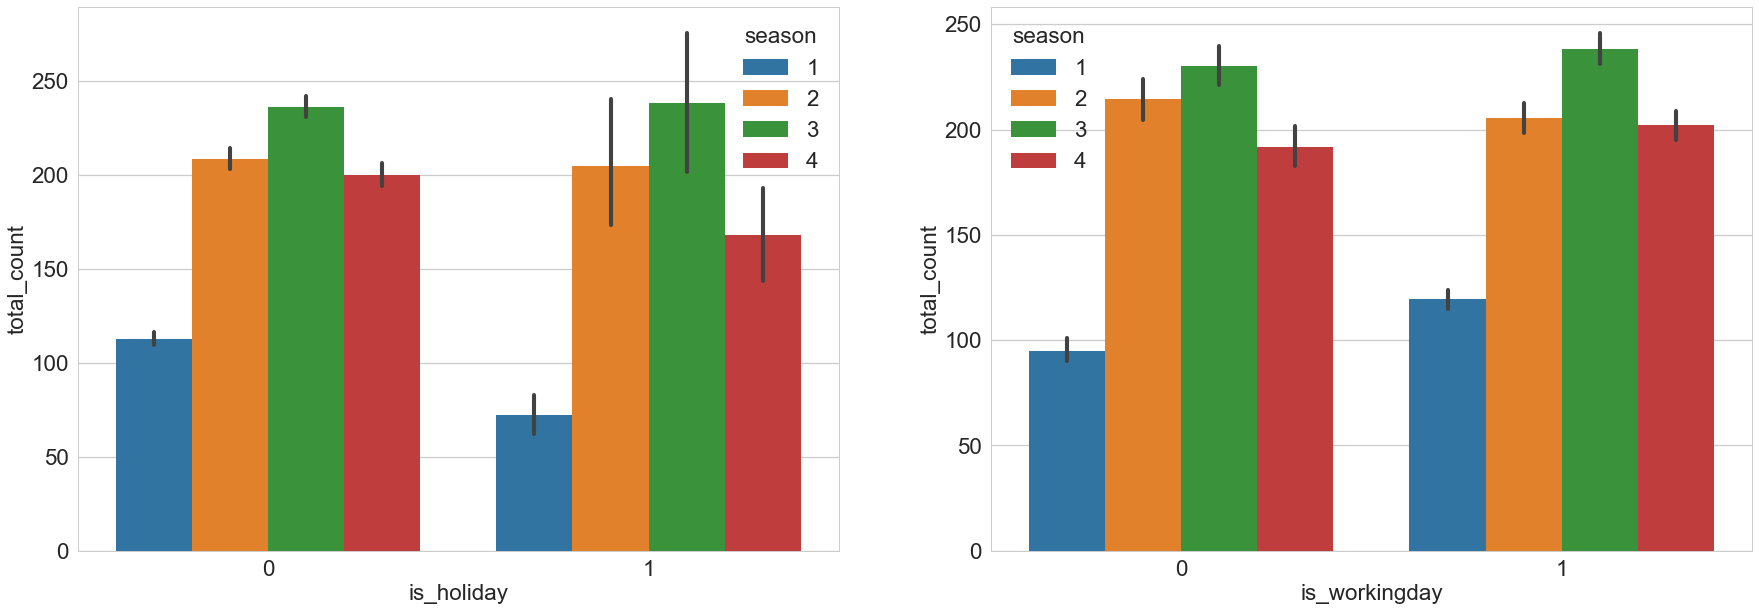

In [204]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
sn.barplot(data=hour_df,x='is_holiday',y='total_count',hue='season',ax=ax1)
sn.barplot(data=hour_df,x='is_workingday',y='total_count',hue='season',ax=ax2)

# Outliers

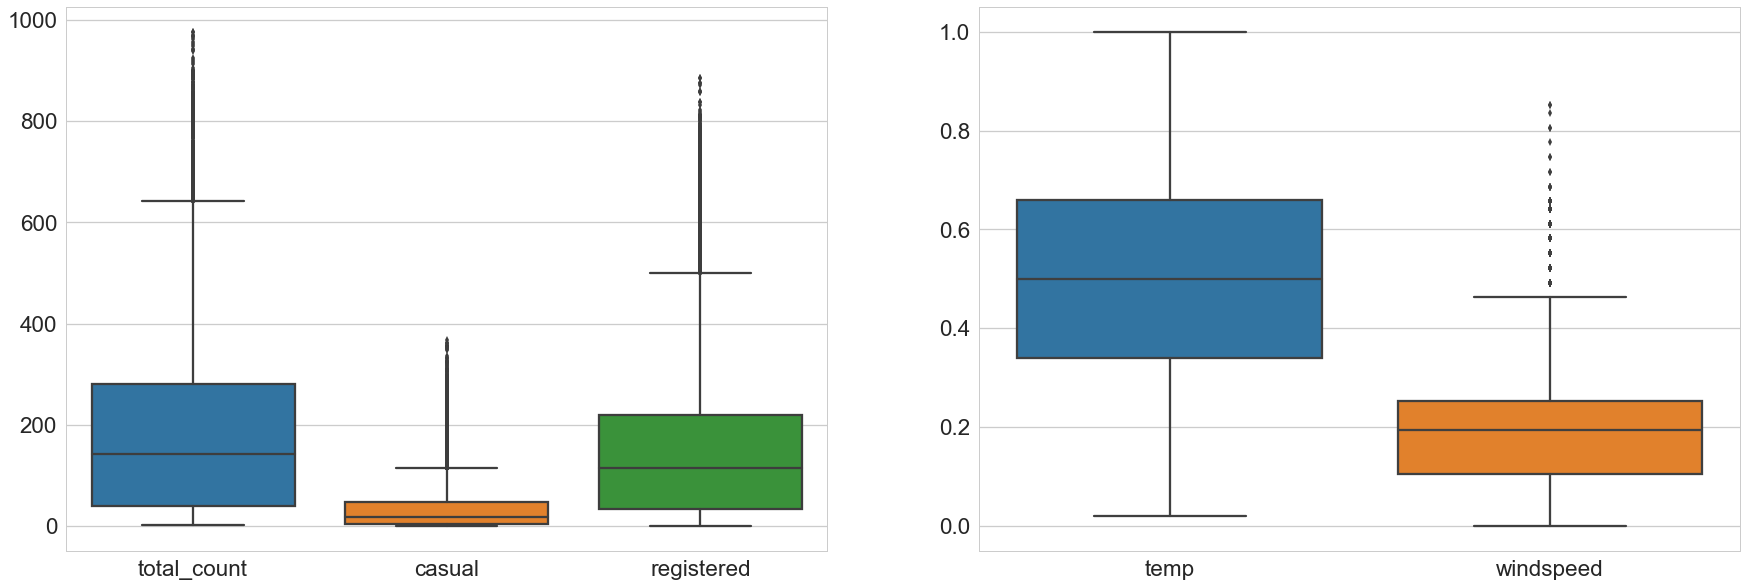

In [205]:
#compare casual vs registered
#The outliers here result from temperature, windspeed ,as well as because of casual bikers
fig,(ax1,ax2)= plt.subplots(ncols=2)
sn.boxplot(data=hour_df[['total_count','casual','registered']],ax=ax1)
sn.boxplot(data=hour_df[['temp','windspeed']],ax=ax2)

# Correlations

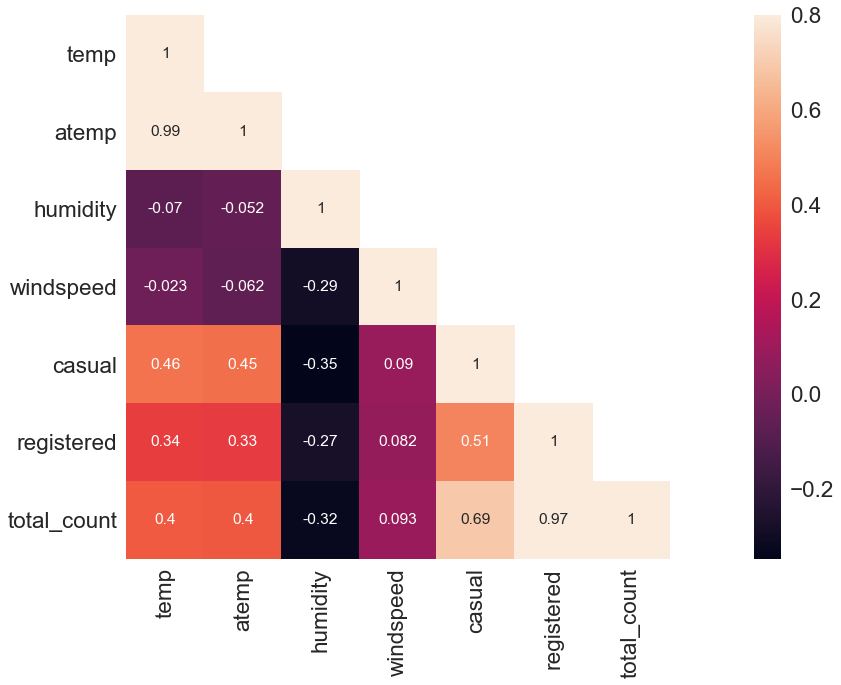

In [206]:
corrMatt = hour_df[["temp","atemp","humidity","windspeed","casual","registered","total_count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
#Windspeed to humidity has negative correlation.Overall correlational statistics are not very high.
#As expected temp and atemp has strong positive colleration

# Encode Categoricals (One Hot Encoding)

In [207]:
#The arguments are df(pandas.DataFrame) containing col_name: the column to be one hot encoded
#The Returns are label_encoder, one_hot_encoder, transformed column as pandas Series
def fit_transform_ohe(df,col_name):
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df
# given label encoder and one hot encoder objects,encode attribute to ohe
#The function performs one hot encoding for the specified column using the specified encoder objects.
#Args: df(pandas.DataFrame): the data frame containing the mentioned column name
#le(Label Encoder): the label encoder object used to fit label encoding
#ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
#col_name: the column to be one hot encoded
#Returns:tuple: transformed column as pandas Series
def transform_ohe(df,le,ohe,col_name):
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return features_df